# Compare Seasonal Climatology from Xarray and CDAT


by Jiwoo Lee (LLNL)

In this document, I compare seasonal climatology fields calculated using Xarray and CDAT. 

Useful resources:
- [xarray instrcution](https://nci-data-training.readthedocs.io/en/latest/_notebook/climate/1_01_Xarray_access_CMIP5.html)

Environment:
```
conda create -y -n cdat_v8.2.1 -c conda-forge -c cdat/label/v8.2.1 cdat "libnetcdf=*=mpi_openmpi_*" "mesalib=17.3.9" "python=3.7"
conda activate cdat_v8.2.1
conda install -c conda-forge xarray 
conda install -c conda-forge netcdf4 
```

## Input data

In [1]:
path = "ts_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412.nc"

## Xarray

In [2]:
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

### Load data

In [3]:
%%time
f = xr.open_dataset(path, decode_times=True)
d = f.ts

CPU times: user 23.9 ms, sys: 7.59 ms, total: 31.5 ms
Wall time: 30.1 ms


### Calculating Seasonal Averages from Timeseries of Monthly Means
http://xarray.pydata.org/en/stable/examples/monthly-means.html

In [4]:
def season_mean(ds, calendar='standard'):
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.season'
    weights = month_length.groupby('time.season') / month_length.groupby('time.season').sum()

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby('time.season').sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weights).groupby('time.season').sum(dim='time')

In [5]:
d = d[2:-1]  # Exclude first Jan, Feb and last Dec
d_season_mean = season_mean(d) - 273.15

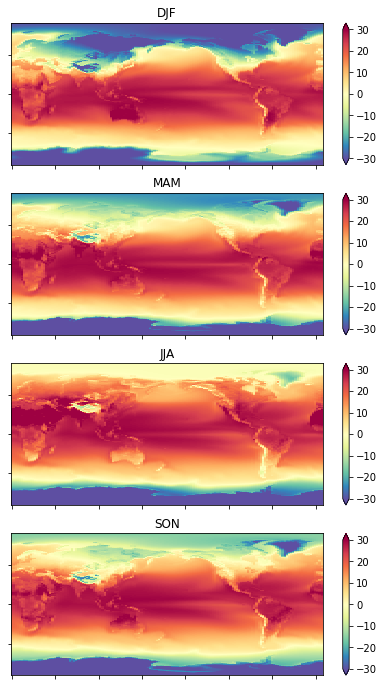

In [6]:
# Quick plot to show the results
notnull = pd.notnull(d[0])

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(7,12))
for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    d_season_mean.sel(season=season).where(notnull).plot.pcolormesh(
        ax=axes[i], vmin=-30, vmax=30, cmap='Spectral_r',
        add_colorbar=True, extend='both')
    axes[i].set_title(season)

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

## CDMS

### Load data

In [7]:
import cdms2
import cdutil

f2 = cdms2.open(path)

In [8]:
%%time

d2 = f2('ts')

CPU times: user 806 ms, sys: 206 ms, total: 1.01 s
Wall time: 1.02 s


In [9]:
d2.shape

(1980, 143, 144)

### Calculate Seasonal Climatology

In [10]:
%%time

d2 = d2(time=slice(2,-1))  # Exclude first Jan, Feb and last Dec

d2_djf = cdutil.DJF.climatology(d2)(squeeze=1) - 273.15
d2_mam = cdutil.MAM.climatology(d2)(squeeze=1) - 273.15
d2_jja = cdutil.JJA.climatology(d2)(squeeze=1) - 273.15
d2_son = cdutil.SON.climatology(d2)(squeeze=1) - 273.15

CPU times: user 2.79 s, sys: 262 ms, total: 3.05 s
Wall time: 3.07 s


### Convert CDAT transient variable to Xarray data array for plotting purpose

In [11]:
lat = d2_djf.getLatitude()
lon = d2_djf.getLongitude()

In [12]:
d2_djf_xr = xr.DataArray(d2_djf, coords=[list(lat), list(lon)], dims=["lat", "lon"])
d2_mam_xr = xr.DataArray(d2_mam, coords=[list(lat), list(lon)], dims=["lat", "lon"])
d2_jja_xr = xr.DataArray(d2_jja, coords=[list(lat), list(lon)], dims=["lat", "lon"])
d2_son_xr = xr.DataArray(d2_son, coords=[list(lat), list(lon)], dims=["lat", "lon"])

In [13]:
d2_djf_xr

<xarray.DataArray 'variable_1328' (lat: 143, lon: 144)>
array([[-32.60756284, -32.60756284, -32.60756284, ..., -32.60756284,
        -32.60756284, -32.60756284],
       [-30.98411498, -31.05047019, -31.13768807, ..., -30.75902247,
        -30.84254302, -30.8821338 ],
       [-30.51614572, -30.65714768, -30.80217072, ..., -30.09390053,
        -30.23297249, -30.35141599],
       ...,
       [-28.61648434, -28.52463677, -28.47774577, ..., -28.84370836,
        -28.71560133, -28.64734385],
       [-28.89134727, -28.84836428, -28.8219739 , ..., -28.97231478,
        -28.97312876, -28.96374254],
       [-30.29514151, -30.29514151, -30.29514151, ..., -30.29514151,
        -30.29514151, -30.29514151]])
Coordinates:
  * lat      (lat) float32 -90.0 -88.73239 -87.46479 ... 87.46479 88.73239 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

In [14]:
d2_season = {}
d2_season['DJF'] = d2_djf_xr
d2_season['MAM'] = d2_mam_xr
d2_season['JJA'] = d2_jja_xr
d2_season['SON'] = d2_son_xr

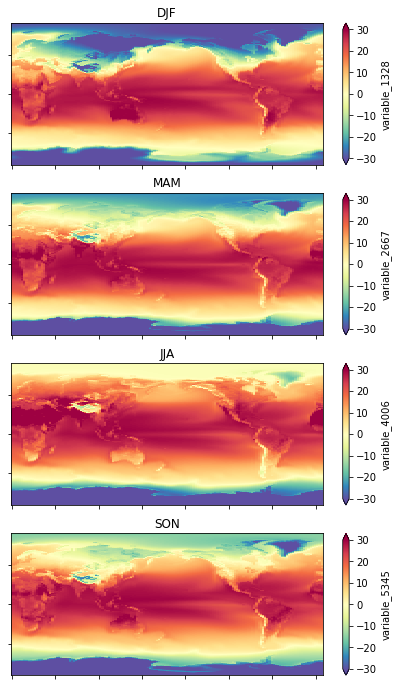

In [15]:
# Quick plot to show the results
notnull = pd.notnull(d[0])

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(7,12))
for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    d2_season[season].where(notnull).plot.pcolormesh(
        ax=axes[i], vmin=-30, vmax=30, cmap='Spectral_r',
        add_colorbar=True, extend='both')
    axes[i].set_title(season)

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

## Check Difference

Text(0.5, 1.02, 'Seasonal Surface Air Temperature')

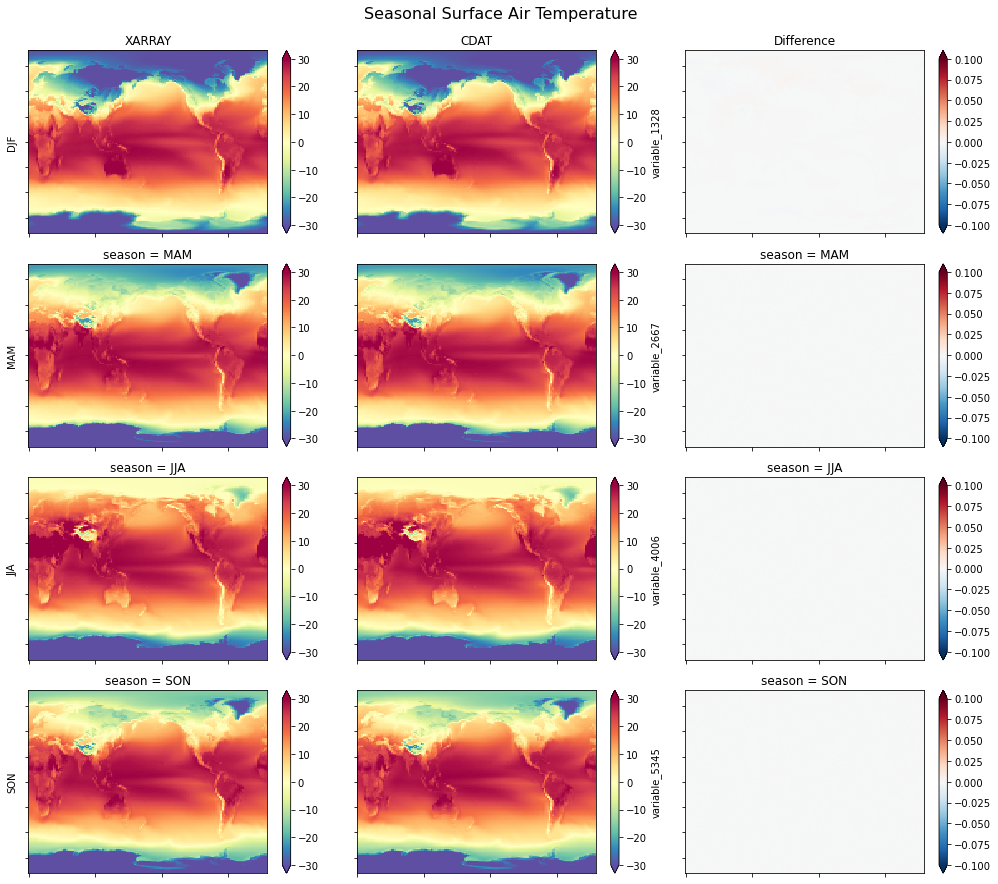

In [16]:
# Quick plot to show the results
notnull = pd.notnull(d[0])

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(14,12))
for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    d_season_mean.sel(season=season).where(notnull).plot.pcolormesh(
        ax=axes[i, 0], vmin=-30, vmax=30, cmap='Spectral_r',
        add_colorbar=True, extend='both')

    d2_season[season].where(notnull).plot.pcolormesh(
        ax=axes[i, 1], vmin=-30, vmax=30, cmap='Spectral_r',
        add_colorbar=True, extend='both')

    (d2_season[season]-d_season_mean.sel(season=season)).where(notnull).plot.pcolormesh(
        ax=axes[i, 2], vmin=-0.1, vmax=.1, cmap='RdBu_r',
        add_colorbar=True, extend='both')

    axes[i, 0].set_ylabel(season)
    axes[i, 1].set_ylabel('')
    axes[i, 2].set_ylabel('')

for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis('tight')
    ax.set_xlabel('')

axes[0, 0].set_title('XARRAY')
axes[0, 1].set_title('CDAT')
axes[0, 2].set_title('Difference')

plt.tight_layout()

fig.suptitle('Seasonal Surface Air Temperature', fontsize=16, y=1.02)